# Dealing with Bias and Fairness in Data Science Systems
## KDD 2020 Hands-on Tutorial
### Pedro Saleiro, Kit Rodolfa, Rayid Ghani

# <font color=red>Auditing a Single Model using [Aequitas](http://www.datasciencepublicpolicy.org/projects/aequitas/)</font>
A more in-depth demo notebook is at https://github.com/dssg/aequitas/blob/master/docs/source/examples/compas_demo.ipynb

### 1. Install dependencies, import packages and data
This is needed every time you open this notebook in colab to install dependencies

In [1]:
!pip install aequitas
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))
import yaml
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap
DATAPATH = 'https://github.com/dssg/fairness_tutorial/raw/master/data/'
DPI = 200


     |████████████████████████████████| 2.2MB 4.5MB/s 
     |████████████████████████████████| 163kB 33.5MB/s 
     |████████████████████████████████| 276kB 32.4MB/s 
     |████████████████████████████████| 102kB 7.6MB/s 
     |████████████████████████████████| 460kB 34.6MB/s 
     |████████████████████████████████| 92kB 8.8MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 81kB 8.5MB/s 
     |████████████████████████████████| 2.6MB 34.2MB/s 
  Created wheel for markdown2: filename=markdown2-2.3.5-cp36-none-any.whl size=33312 sha256=b0705441cfe0b178016e2628e45b5c7b7da2fd22f6afca60b0e982b57d428f39
  Stored in directory: /root/.cache/pip/wheels/07/99/0b/89995aca5b1253b89caa7de4041fabea6fba469f42da697664
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=6e88095c00c5d7d8d127482400deff7ffb050824597a92f489e8e9f7ceb27d32
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea31

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## What has already happened?

We've already cleaned data, generated features, created train-test sets, built 1000s of models on each training set and scored each test set with them, and calculated various evaluation metrics. 

As described earlier, the goal here is to select top 1000 project submissions that are likely to not get funded in order to prioritize resource allocation. That corresponds to the metric **Preicision at top 1000**.


## Let's take a look at the performance of the models on one test set based on  **Preicision at top 1000**

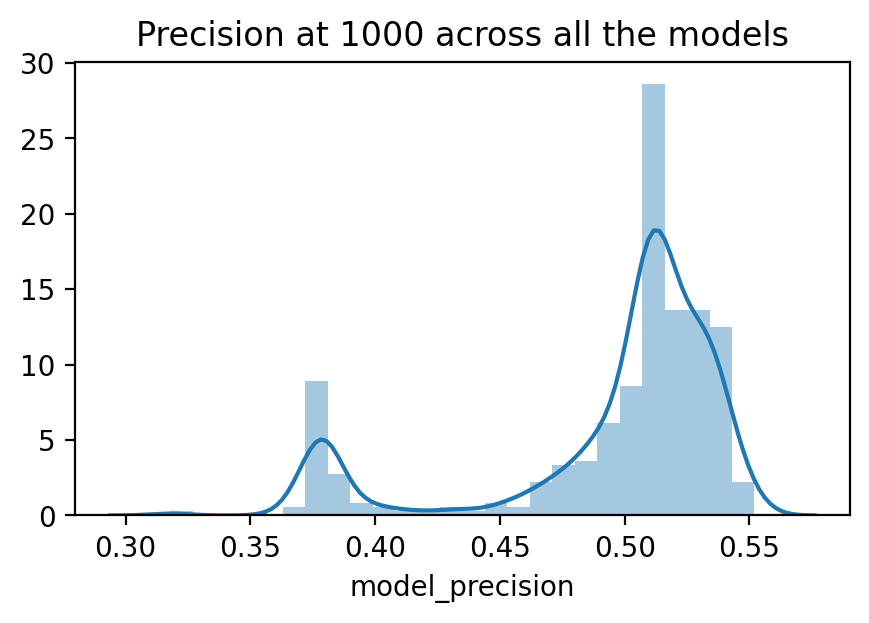

In [2]:
# code to load results and plot histogram with p@1000 for all models
evals_df = pd.read_csv(DATAPATH +'split2_evals.csv.gz', compression='gzip')

ax = sns.distplot(evals_df['model_precision'])
ax.set_title('Precision at 1000 across all the models')
plt.gcf().set_size_inches((5, 3))
plt.gcf().set_dpi(DPI)
plt.show()

## We're now going to take the "best" model based on precision at top 1000 and audit its predicitons

# <font color=green>Auditing the Model with Highest Precision at top 1000</font>

### What do we need to audit the predictions?
1. predictions (scores or thresholded based on top 1000)
2. labels
3. attributes to audit (and a reference group within each attribute)
4. fairness metric(s)
5. disparity tolerance

## Load predictions, labels, and attributes to audit

In [3]:
# load pre-computed predictions, labels, attributes dataframe
df = pd.read_csv(DATAPATH + 'single_audit_df.csv.gz', compression='gzip')

Aequitas needs predictions (binary score), the label value, and the attributes to audit

In [4]:
# take a look at the dataframe we just loaded
df.head(10)

,score,label_value,poverty_level,metro_type,teacher_sex
0,0.0,0.0,lower,suburban_rural,female
1,0.0,0.0,highest,unknown,female
2,0.0,1.0,lower,suburban_rural,female
3,0.0,0.0,lower,unknown,female
4,0.0,0.0,lower,urban,female
5,0.0,1.0,lower,unknown,female
6,0.0,0.0,highest,urban,female
7,0.0,0.0,highest,unknown,female
8,0.0,1.0,lower,unknown,female
9,0.0,0.0,highest,unknown,female


In [5]:
# The score has been binarized (0/1) by taking the top 1000 highest scored predictions and calling them 1 
# because we care about selecting the top 1000 projects)
df['score'].value_counts()

0.0    16677
1.0     1000
Name: score, dtype: int64

## Define Attributes to Audit and Reference Group for each Attribute

In [6]:
attributes_and_reference_groups={'poverty_level':'lower', 'metro_type':'suburban_rural', 'teacher_sex':'male'}
attributes_to_audit = list(attributes_and_reference_groups.keys())

## Select fairness metric(s) that we care about

In [7]:
metrics = ['tpr']

## Define  Disparity Tolerance 

In [8]:
disparity_tolerance = 1.30

## Run Aequitas (based on the settings above)

In [9]:
# Initialize Aequitas
g = Group()
b = Bias()

# get_crosstabs returns a dataframe of the group counts and group value bias metrics.
xtab, _ = g.get_crosstabs(df, attr_cols=attributes_to_audit)
bdf = b.get_disparity_predefined_groups(xtab, original_df=df, ref_groups_dict=attributes_and_reference_groups)

model_id, score_thresholds 0 {'rank_abs': [1000]}
get_disparity_predefined_group()


## Look at Audit Results

Now we are going to focus our analysis on the fairness metric(s) of interest in this case study: TPR across different groups. The aequitas plot module exposes the disparities_metrics() plot, which displays both the disparities and the group-wise metric results side by side.

### Check for Fairness in Poverty Level 

In [10]:
ap.disparities_metrics(bdf, metrics, 'poverty_level', fairness_threshold = disparity_tolerance)

alt.HConcatChart(...)

### Check for Fairness in Metro_Type (where the school is based)

In [11]:
ap.disparities_metrics(bdf, metrics, 'metro_type', fairness_threshold = disparity_tolerance)

alt.HConcatChart(...)

### Check for Fairness in the Sex of the Teacher submitting the project 

In [12]:
ap.disparities_metrics(bdf, metrics, 'teacher_sex', fairness_threshold = disparity_tolerance)

alt.HConcatChart(...)

### Deeper Dive into the audit results

#### Look at the underlying data: Disparities for all metrics 

In [13]:
bdf[['attribute_name', 'attribute_value'] + b.list_disparities(bdf)]

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,poverty_level,highest,0.328021,0.253392,1.222528,0.755777,0.856807,0.175102,1.101013,0.368285,1.065999,1.078633
1,poverty_level,lower,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,metro_type,suburban_rural,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,metro_type,unknown,0.290735,0.920000,1.022572,0.974346,1.014413,0.902491,1.011319,0.929977,1.007479,0.992228
4,metro_type,urban,0.306709,0.218919,1.174925,0.801195,0.861141,0.160353,1.112078,0.306665,1.064402,1.074882
5,teacher_sex,female,19.408163,3.322778,1.086141,0.910270,1.037782,3.127991,0.925731,3.370670,0.970598,0.982642
6,teacher_sex,male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Look at the underlying data: All Metrics

In [14]:
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[['attribute_name', 'attribute_value'] + absolute_metrics]

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,poverty_level,highest,0.050771,0.987028,0.303722,0.360324,0.012972,0.949229,0.696278,0.639676,0.247,0.024767,0.312043
1,poverty_level,lower,0.137859,0.925918,0.354481,0.476760,0.074082,0.862141,0.645519,0.523240,0.753,0.097741,0.370976
2,metro_type,suburban_rural,0.139156,0.928762,0.350340,0.468051,0.071238,0.860844,0.649660,0.531949,0.626,0.096219,0.367814
3,metro_type,unknown,0.129412,0.935709,0.355390,0.456044,0.064291,0.870588,0.644610,0.543956,0.182,0.088521,0.372082
4,metro_type,urban,0.042674,0.988577,0.301692,0.375000,0.011423,0.957326,0.698308,0.625000,0.192,0.021064,0.308502
5,teacher_sex,female,0.102390,0.957370,0.326686,0.445846,0.042630,0.897610,0.673314,0.554154,0.951,0.063009,0.341019
6,teacher_sex,male,0.030377,0.986371,0.314793,0.489796,0.013629,0.969623,0.685207,0.510204,0.049,0.018963,0.318498


#### Look at the underlying data: All raw counts

In [15]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,1000,poverty_level,highest,247,9726,89,2954,6772,158,3112,6861,9973,17677
1,0,binary 0/1,1000,poverty_level,lower,753,6951,359,2464,4487,394,2858,4846,7704,17677
2,0,binary 0/1,1000,metro_type,suburban_rural,626,5880,293,2060,3820,333,2393,4113,6506,17677
3,0,binary 0/1,1000,metro_type,unknown,182,1874,83,666,1208,99,765,1291,2056,17677
4,0,binary 0/1,1000,metro_type,urban,192,8923,72,2692,6231,120,2812,6303,9115,17677
5,0,binary 0/1,1000,teacher_sex,female,951,14142,424,4620,9522,527,5147,9946,15093,17677
6,0,binary 0/1,1000,teacher_sex,male,49,2535,24,798,1737,25,823,1761,2584,17677
